In [2]:
# import libraries used throughout the notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn
import math
from sklearn import svm, metrics, ensemble
from sklearn.model_selection import train_test_split

In [3]:
#check version
sklearn.__version__

'1.5.0'

The dataset we use is from the paper <a href="https://www.researchgate.net/publication/228780408_Using_data_mining_to_predict_secondary_school_student_performance">Using data mining to predict secondary school student performance</a> by Paulo Cortez and Alice Silva.

The following blocks use the Portugese dataset.

In [4]:
data = pd.read_csv('data/student-por.csv', delimiter=';')
# heatmap requires numerical values
data = data.replace(to_replace=['M', 'F'], value=[0,1]) #sex
data = data.replace(to_replace=['GP', 'MS'], value=[0,1]) #school
data = data.replace(to_replace=['A', 'T'], value=[0,1]) #Pstatus
data = data.replace(to_replace=['GT3', 'LE3'], value=[0,1]) #famsize
data = data.replace(to_replace=['U', 'R'], value=[0,1]) #address
data = data.replace(to_replace=['father', 'mother'], value=[0,1]) #guardian
data = data.replace(to_replace=['at_home', 'health', 'other', 'services', 'teacher'], value=[0,1,2,3,4]) #Mjob, Fjob
data = data.replace(to_replace=['course', 'other', 'home', 'reputation'], value=[0,1,2,3]) #reason
data = data.replace(to_replace=['no', 'yes'], value=[0,1]) #fatherd, nursery, higher, famsup, romantic
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,1,18,0,0,0,4,4,0,4,...,4,3,4,1,1,3,4,0,11,11
1,0,1,17,0,0,1,1,1,0,2,...,5,3,3,1,1,3,2,9,11,11
2,0,1,15,0,1,1,1,1,0,2,...,4,3,2,2,3,3,6,12,13,12
3,0,1,15,0,0,1,4,2,1,3,...,3,2,2,1,1,5,0,14,14,14
4,0,1,16,0,0,1,3,3,2,2,...,4,3,2,1,2,5,0,11,13,13


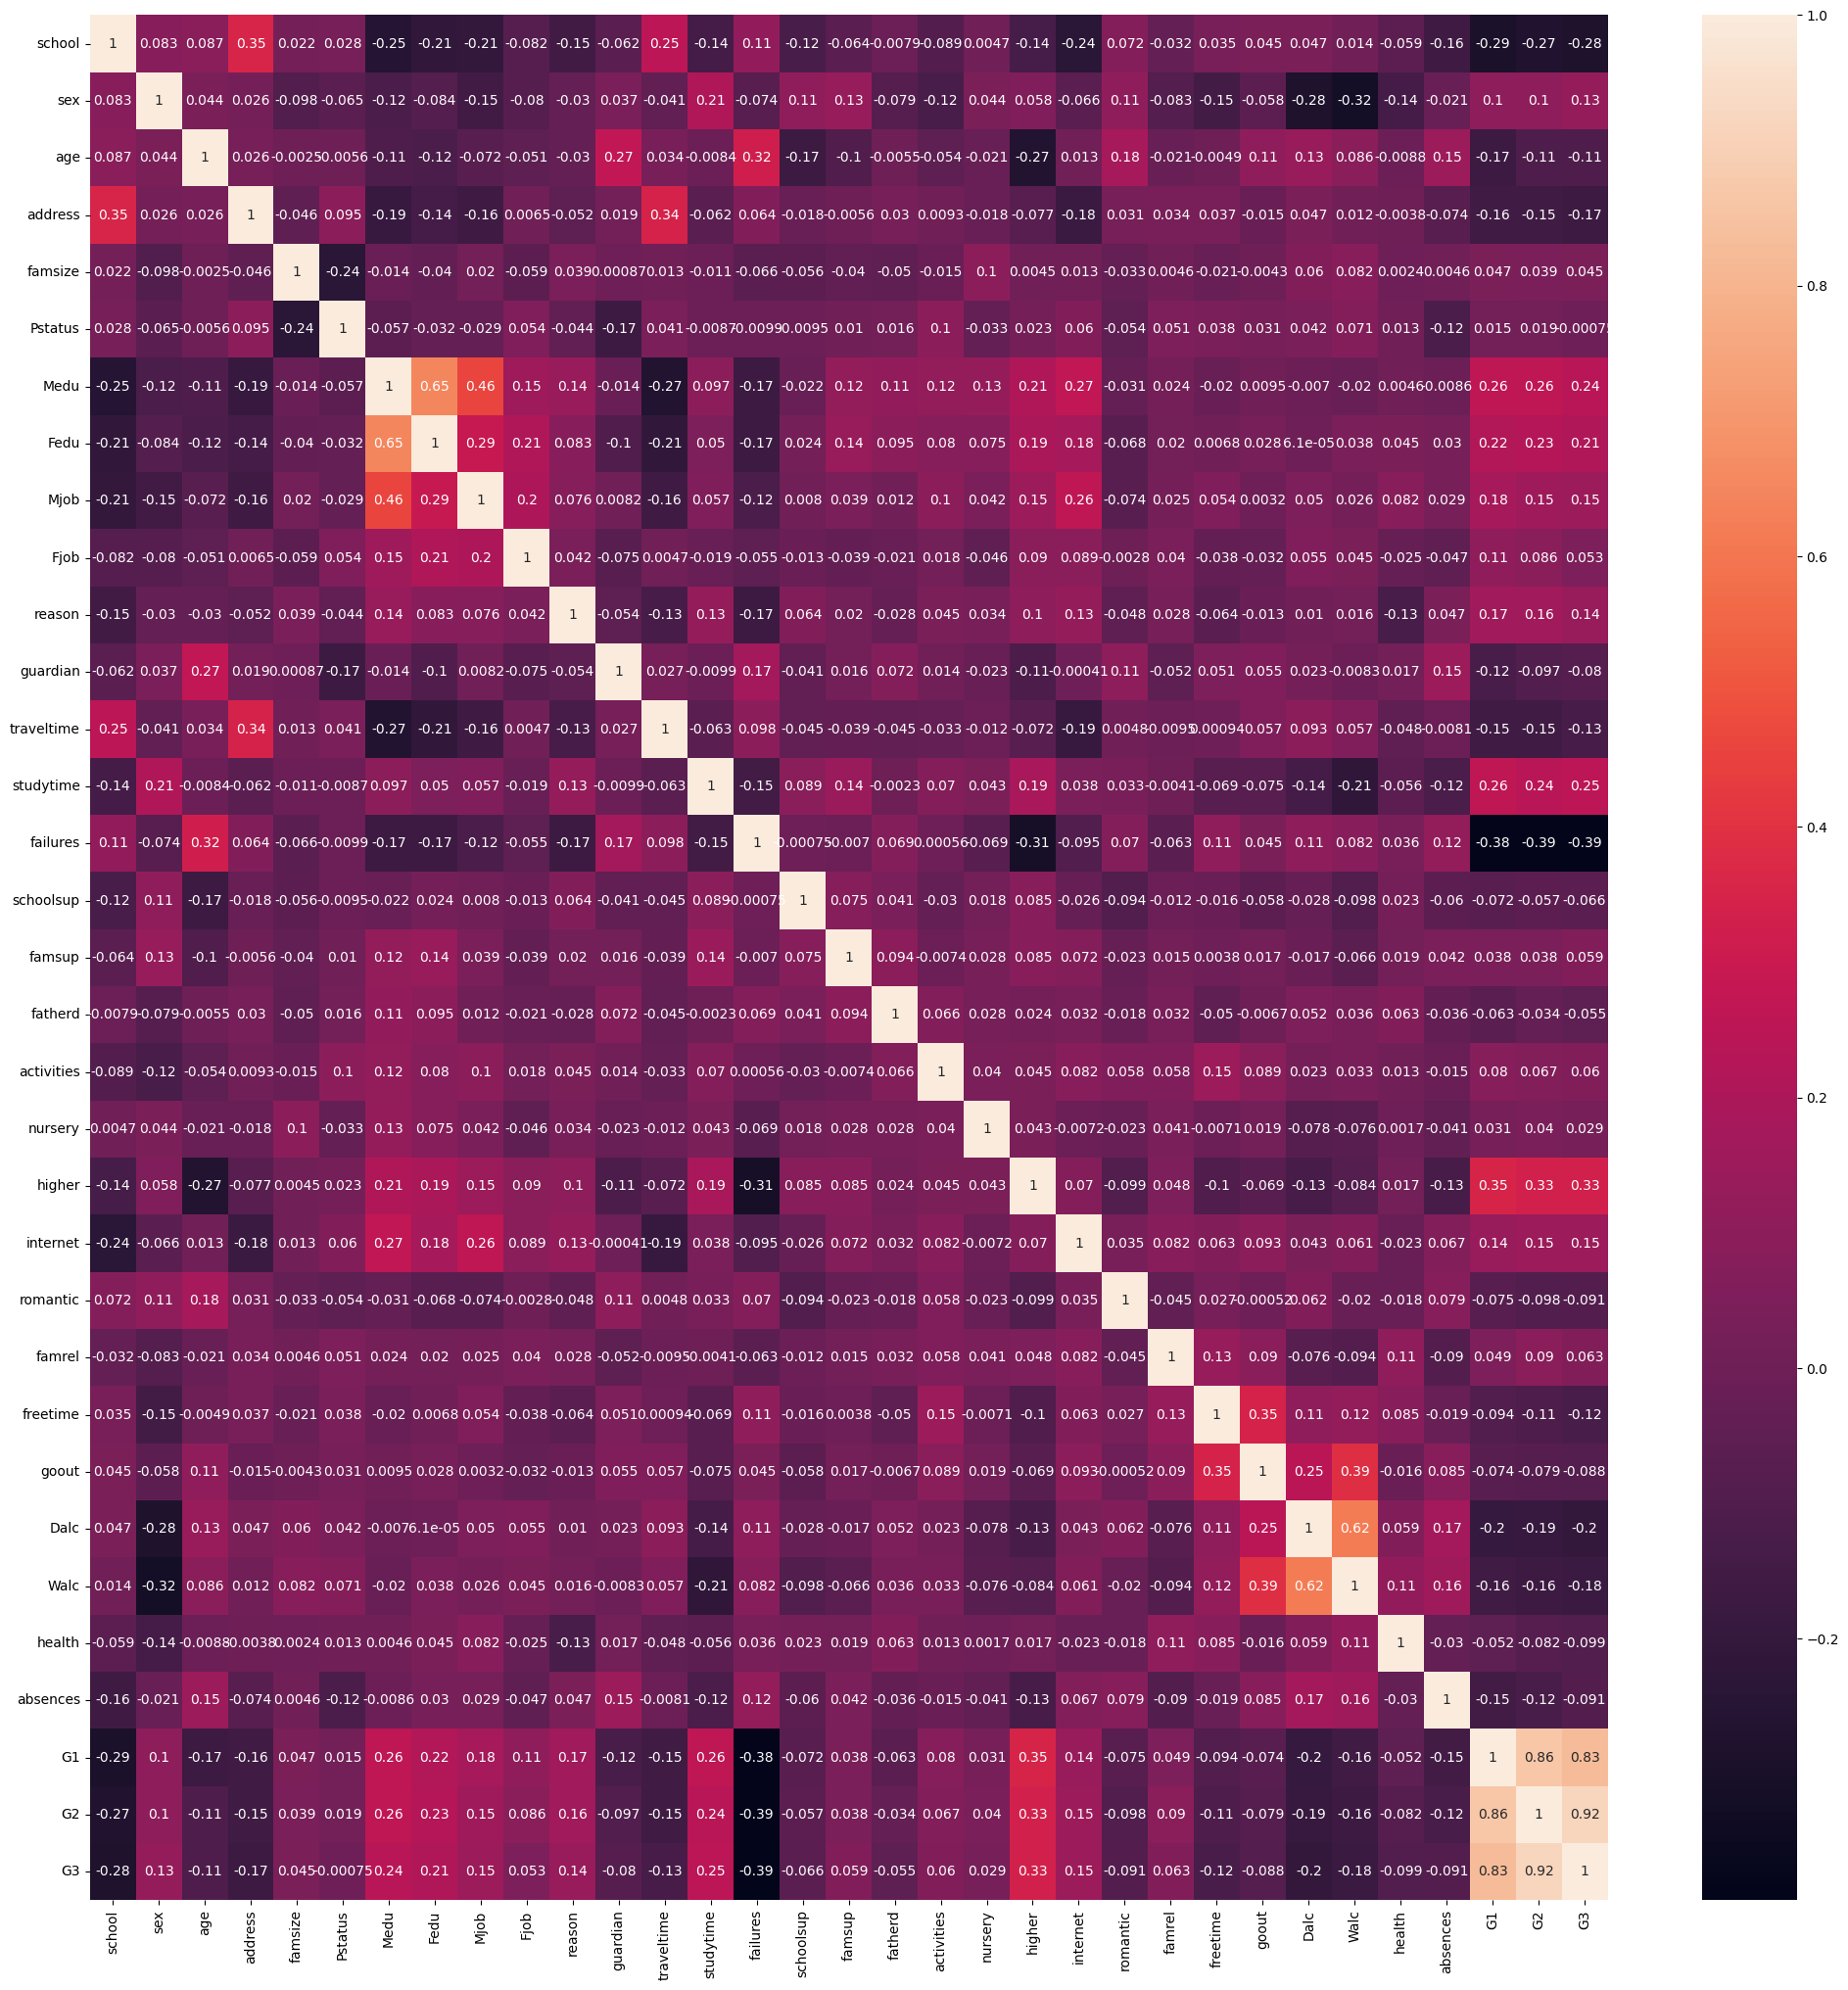

In [5]:
# add correlation matrix to see which features are highly correlated
corr_data = data.select_dtypes(include='number')
corr = corr_data.corr()
fig, ax = plt.subplots(figsize=(25,25))
ax = sns.heatmap(corr, annot=True)

# features highly correlated with sex: Dalc(-), Walc(-), studytime, freetime(-), Mjob(-), health(-), G3, famsup, Medu(-), romantic

In [6]:
# split data for training and testing (80:20), use all features except predictor and sensitive attribute
features = data
X = features.drop(columns=['G3', 'sex'])
y = data['G3'] # predict final grade
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# binary classifier: pass if >= 10, else fail

# redefine values for binary classification
y_train_binary = y_train.tolist()
y_test_binary = y_test.tolist()
for i in range(len(y_train_binary)):
    if y_train_binary[i] >= 10:
        y_train_binary[i] = 1
    else:
        y_train_binary[i] = 0
for i in range(len(y_test_binary)):
    if y_test_binary[i] >= 10:
        y_test_binary[i] = 1
    else:
        y_test_binary[i] = 0

# we use SVM, paper tried 5 different models
clf = svm.SVC().fit(X_train, y_train_binary)
pred = clf.predict(X_test)
metrics.accuracy_score(y_test_binary, pred) # 93.1% accuracy

0.9307692307692308

In [8]:
# 5 level classification as defined in paper
y_train_5 = y_train.replace(to_replace=[[20, 19, 18, 17, 16], [15, 14], [13, 12], [11, 10], [9,8,7,6,5,4,3,2,1]], value=[1, 2, 3, 4, 5])
y_test_5 = y_test.replace(to_replace=[[20, 19, 18, 17, 16], [15, 14], [13, 12], [11, 10], [9,8,7,6,5,4,3,2,1]], value=[1, 2, 3, 4, 5])
clf = svm.SVC().fit(X_train, y_train_5)
pred = clf.predict(X_test)
metrics.accuracy_score(y_test_5, pred) # 70% accuracy

0.7

In [9]:
# regression: score determined by RMSE

regr = svm.SVR().fit(X_train, y_train)
pred = regr.predict(X_test)
metrics.mean_squared_error(y_test, pred) # 1.70

1.6980659535368896

In [10]:
# classification: try to predict sensitive attribute (sex) using highly correlated features
features = data[['Dalc', 'Walc', 'studytime', 'freetime']]
X = features
y = data['sex']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = svm.SVC().fit(X_train, y_train)
pred = clf.predict(X_test)
metrics.accuracy_score(y_test, pred) # 75.4% accuracy

0.7538461538461538

In [11]:
# classification: predict sensitive attribute using all features except predictor, grades
features = data
X = features.drop(columns=['G1', 'G2', 'G3', 'sex'])
y = data['sex']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = svm.SVC().fit(X_train, y_train)
pred = clf.predict(X_test)
metrics.accuracy_score(y_test, pred) #67.7% accuracy

0.7307692307692307

In [12]:
# classification: predict sensitive attribute using all features except predictor, grades
features = data
X = features.drop(columns=['G1', 'G2', 'G3', 'Pstatus'])
y = data['Pstatus']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = svm.SVC().fit(X_train, y_train)
pred = clf.predict(X_test)
metrics.accuracy_score(y_test, pred) #83.8% accuracy

0.8384615384615385

The following blocks use the Mathematics dataset.

In [15]:
data = pd.read_csv('data/student-mat.csv', delimiter=';')
# heatmap requires numerical values
data = data.replace(to_replace=['M', 'F'], value=[0,1]) #sex
data = data.replace(to_replace=['GP', 'MS'], value=[0,1]) #school
data = data.replace(to_replace=['A', 'T'], value=[0,1]) #Pstatus
data = data.replace(to_replace=['GT3', 'LE3'], value=[0,1]) #famsize
data = data.replace(to_replace=['U', 'R'], value=[0,1]) #address
data = data.replace(to_replace=['father', 'mother'], value=[0,1]) #guardian
data = data.replace(to_replace=['at_home', 'health', 'other', 'services', 'teacher'], value=[0,1,2,3,4]) #Mjob, Fjob
data = data.replace(to_replace=['course', 'other', 'home', 'reputation'], value=[0,1,2,3]) #reason
data = data.replace(to_replace=['no', 'yes'], value=[0,1]) #fatherd, nursery, higher, famsup, romantic
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,1,18,0,0,0,4,4,0,4,...,4,3,4,1,1,3,6,5,6,6
1,0,1,17,0,0,1,1,1,0,2,...,5,3,3,1,1,3,4,5,5,6
2,0,1,15,0,1,1,1,1,0,2,...,4,3,2,2,3,3,10,7,8,10
3,0,1,15,0,0,1,4,2,1,3,...,3,2,2,1,1,5,2,15,14,15
4,0,1,16,0,0,1,3,3,2,2,...,4,3,2,1,2,5,4,6,10,10


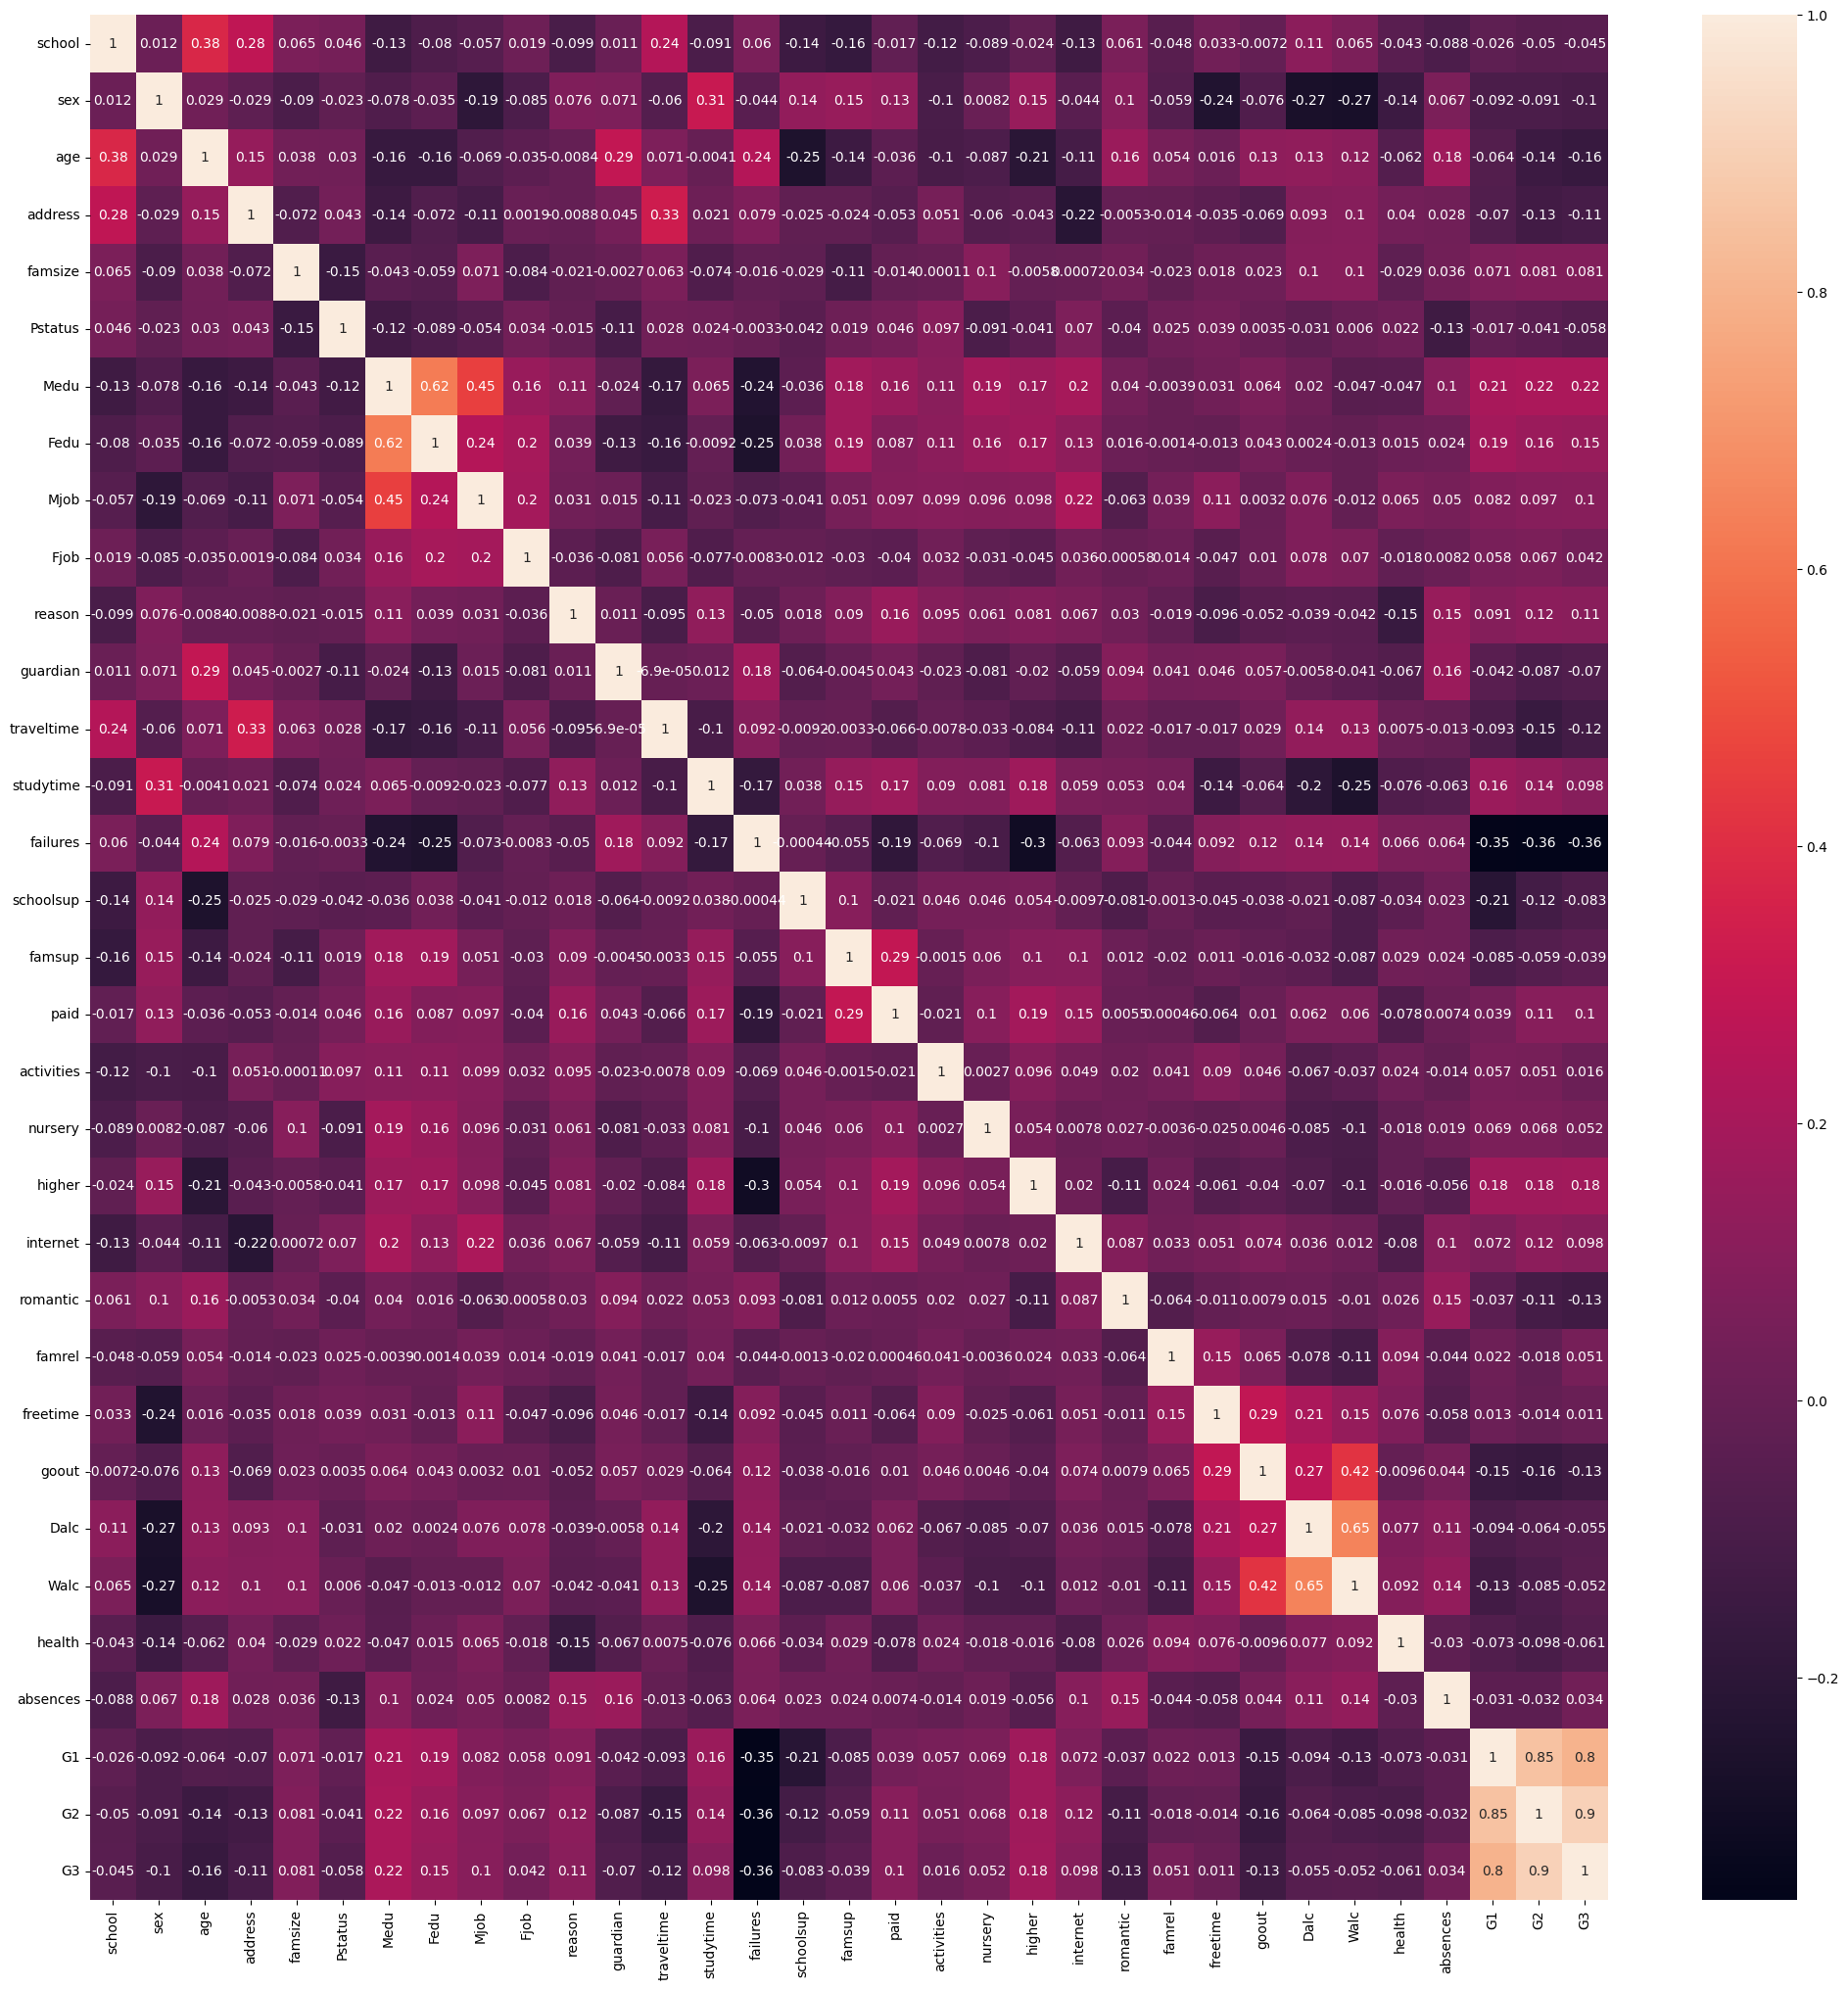

In [16]:
# add correlation matrix to see which features are highly correlated
corr_data = data.select_dtypes(include='number')
corr = corr_data.corr()
fig, ax = plt.subplots(figsize=(25,25))
ax = sns.heatmap(corr, annot=True)

# features highly correlated with sex: studytime, Dalc(-), Walc(-), freetime(-), Mjob(-), higher, schoolsup, famsup, health(-), paid

In [89]:
# RF classifier: predict sex from features
features = data[['studytime', 'Walc', 'freetime', 'Mjob', 'schoolsup', 'health']]
X = features
y = data['sex']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = ensemble.RandomForestClassifier().fit(X_train, y_train)
pred = clf.predict(X_test)
metrics.accuracy_score(y_test, pred)
metrics.f1_score(y_test, pred)

0.5714285714285714

In [90]:
# SVM classifier: predict sex from features
features = data[['studytime', 'Walc', 'freetime', 'Mjob', 'schoolsup', 'health']]
X = features
y = data['sex']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = svm.SVC().fit(X_train, y_train)
pred = clf.predict(X_test)
metrics.accuracy_score(y_test, pred)
metrics.f1_score(y_test, pred)
print(metrics.classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.65      0.59      0.62        41
           1       0.60      0.66      0.62        38

    accuracy                           0.62        79
   macro avg       0.62      0.62      0.62        79
weighted avg       0.62      0.62      0.62        79



In [91]:
# RF classifier: predict cohabitation from features
features = data[['studytime', 'Walc', 'freetime', 'Mjob', 'schoolsup', 'health']]
X = features
y = data['Pstatus']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
clf = ensemble.RandomForestClassifier().fit(X_train, y_train)
pred = clf.predict(X_test)
metrics.accuracy_score(y_test, pred)
metrics.f1_score(y_test, pred)
print(metrics.classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.75      0.21      0.33        14
           1       0.90      0.99      0.95       105

    accuracy                           0.90       119
   macro avg       0.83      0.60      0.64       119
weighted avg       0.89      0.90      0.87       119



In [92]:
# SVM classifier: predict cohabitation from features
features = data[['studytime', 'Walc', 'freetime', 'Mjob', 'schoolsup', 'health']]
X = features
y = data['Pstatus']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = svm.SVC().fit(X_train, y_train)
pred = clf.predict(X_test)
metrics.accuracy_score(y_test, pred)
# metrics.f1_score(y_test, pred)

0.8860759493670886

deprecated: we tried making these models, but we decided not to use them in the end

In [ ]:
# regression: predict whether parents are cohabitating
features = data[['famsize', 'guardian', 'address', 'Walc', 'activities', 'romantic', 'internet']]
X = features
y = data['Pstatus']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = sm.add_constant(X_train)
regr = sm.OLS(y_train, X_train).fit()
params = regr.params
regr.summary()

# regression: predict whether student is male or female
features = data[['studytime', 'Walc', 'freetime', 'Mjob', 'schoolsup', 'health']]
X = features
y = data['sex']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = sm.add_constant(X_train)
regr = sm.OLS(y_train, X_train).fit()
params = regr.params
regr.summary()

# SVM classifier: predict combined education from features
data['combined_pedu'] = round((data['Medu'] + data['Fedu']) / 2)
features = data[['studytime', 'Walc', 'freetime', 'Mjob', 'schoolsup', 'health']]
X = features
y = data['combined_pedu']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = svm.SVC().fit(X_train, y_train)
pred = clf.predict(X_test)
metrics.accuracy_score(y_test, pred)
metrics.classification_report(y_test, pred)
# metrics.f1_score(y_test, pred)

# same as above, but this time, use intersectional fairness
data['combined_pedu'] = data['Medu'] + data['Fedu']
features = data[['studytime', 'Walc', 'freetime', 'Mjob', 'schoolsup', 'health']]
X = features
y = data['combined_pedu']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = svm.SVC().fit(X_train, y_train)
pred = clf.predict(X_test)
metrics.accuracy_score(y_test, pred)
# print(metrics.classification_report(y_test, pred))
# metrics.f1_score(y_test, pred)